<a href="https://colab.research.google.com/github/LuigiPagani/POD-and-DL-ROM-for-the-Advection-Diffusion-Equation-Equation/blob/main/POD_%26_DL_ROM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Original Systems
1. **Stokes' Equations:**
   The velocity $b$ and pressure $p$ of the water satisfy:
   $$
   \begin{cases}
   -\Delta b - \nabla p = w_1 f_1 + w_2 f_2 & \text{in } \Omega \\
   \nabla \cdot b = 0 & \text{in } \Omega \\
   b = 0 & \text{on } \partial \Omega
   \end{cases}
   $$
   Here, $f_1$ and $f_2$ represent the influence of two water turbines, and $w_1$ and $w_2$ are their respective strengths.

2. **Convection-Diffusion Equation:**
   The pollutant concentration $u$ satisfies:
   $$
   \begin{cases}
   -\Delta u + b \cdot \nabla u = 0 & \text{in } \Omega \times (0, T) \\
   -\nabla u \cdot n = 0 & \text{on } \partial \Omega \times (0, T) \\
   u(\cdot, 0) = u_0 & \text{in } \Omega
   \end{cases}
   $$

### Deduction of the Modified Equation
Given that $b_1$ and $b_2$ solve the Stokes' equation with $w_1 = 1, w_2 = 0$ and $w_1 = 0, w_2 = 1$ respectively, we can write the general solution $b$ as a linear combination of these basis solutions:
$$
b = w_1 b_1 + w_2 b_2
$$
where $b_1$ and $b_2$ are solutions to the Stokes' equations under the specified conditions.

Inserting this expression for $b$ into the convection-diffusion equation gives:
$$
-\Delta u + (w_1 b_1 + w_2 b_2) \cdot \nabla u = 0 \quad \text{in } \Omega \times (0, T)
$$
This simplifies to:
$$
\begin{cases}
-\Delta u + w_1 b_1 + w_2 b_2 \cdot \nabla u = 0 & \text{in } \Omega \times (0, T) \\
-\nabla u \cdot n = 0 & \text{on } \partial \Omega \times (0, T) \\
u(\cdot, 0) = u_0 & \text{in } \Omega
\end{cases}
$$
Thus, the equation (4) is derived, which allows us to focus solely on the convection-diffusion system by using the precomputed velocity fields $b_1$ and $b_1$ for the different strengths $w_1$ and $w_2$ of the turbines.

In practice, this approach simplifies the computational effort by decoupling the computation of the water's velocity and pressure fields from the pollutant's concentration simulation. Once $b_1$ and $b_2$ are computed, they can be scaled and summed according to $w_1$ and $w_2$ for any scenario, which can significantly reduce computational costs when simulating multiple scenarios with different turbine strengths.

### Equations:
The Stokes' equations are given by:
$$
-\Delta b - \nabla p = f
$$
$$
\nabla \cdot b = 0
$$
where $ f $ represents external forces (in this case, the forces due to the turbines).

### Solving with Specific Turbine Strengths:
1. **When $ w_1 = 1, w_2 = 0 $**:
   - The force term $ f $ in Stokes' equations becomes $ f_1 $.
   - Let $ b_1 $ and $ p_1 $ be the solutions, i.e.,:
     \begin{align*}
     -\Delta b_1 - \nabla p_1 = f_1
     \end{align*}
     \begin{align*}
     \nabla \cdot b_1 = 0
     \end{align*}




2. **When $ w_1 = 0, w_2 = 1 $**:
   - The force term $ f $ now becomes $ f_2 $.
   - Let $ b_2 $ and $ p_2 $ be the solutions, i.e.,:
     \begin{align*}
     -\Delta b_2 - \nabla p_2 = f_2
     \end{align*}
     \begin{align*}
     \nabla \cdot b_2 = 0
     \end{align*}

### Principle of Superposition:
Due to the linearity of the Stokes' equations, if $ b_1 $ and $ b_2 $ are solutions under the respective forces $ f_1 $ and $ f_2 $, any linear combination of these solutions is also a solution for a linear combination of the forces. Specifically:
$$
b = w_1 b_1 + w_2 b_2
$$

$$
-\Delta b - \nabla p = w_1 f_1 + w_2 f_2
$$
$$
\nabla \cdot b = 0
$$
Here, $ w_1 $ and $ w_2 $ act as scaling factors corresponding to the strength of each turbine's influence. This formulation essentially constructs the fluid flow's velocity field as a weighted sum of the two independent velocity fields induced by each turbine separately.


**Installation**

In [1]:
#@title Library Installation
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*
!pip install pyDOE



  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=6b6c2282004512b143fa2d0679730b9176a9a697d7403a0137ae6eb102205a8d
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [13]:
#@title FEM Solver and Snapshots generation
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
from scipy.sparse import csr_matrix
import scipy.sparse as sp

mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1)  # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar=False, bubble=True)  # FE space for b (transport field)

def Stokes_solver(w1, w2):

    # Defining the mixed dimensional space for velocity and pressure

    pP1  = FiniteElement("CG", mesh.ufl_cell(), 1)
    vP1B = VectorElement(NodalEnrichedElement(FiniteElement("CG",       mesh.ufl_cell(), 1),
                                              FiniteElement("Bubble",   mesh.ufl_cell(), mesh.topology().dim() + 1)))

    pspace, vspace = pP1, vP1B
    W = FunctionSpace(mesh, vspace * pspace)
    (b, p) = TrialFunctions(W)
    (v, q) = TestFunctions(W)

    space = fe.space(mesh, "CG", 1, scalar = False, bubble = True)
    x, y = fe.coordinates(space).T
    f1 = -x  + 0.3
    f1[::2] = y[::2] - 0.3
    f1 = f1/((x-0.3)**2 + (y-0.3)**2+1e-8)

    f2 = -x  + 0.7
    f2[::2] = y[::2] - 0.7
    f2 = f2/((x-0.7)**2 + (y-0.7)**2+1e-8)

    f = fe.asvector(w1*f1 - w2*f2, space)

    nu = 1.0

    a = nu*inner(grad(b), grad(v))*dx - div(v)*p*dx - q*div(b)*dx
    L = inner(f, v)*dx
    dbc = DirichletBC(W.sub(0), Constant((0.0, 0.0)), lambda x, on: on)

    A = assemble(a)
    F = assemble(L)

    dbc.apply(A)
    dbc.apply(F)

    A = csr_matrix(A.array())
    F = F[:]

    bp = spsolve(A, F)
    b = bp[W.sub(0).dofmap().dofs()]
    return b


def Convdiff_solver(w1, w2, steps=50, dt=5e-4):
    # Assembling relevant operators
    v1, v2 = TrialFunction(Vh), TestFunction(Vh)
    M = sp.csr_matrix(assemble(v1 * v2 * dx).array())  # mass matrix
    S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2)) * dx).array())  # stiffness (diffusion) matrix

    b = Stokes_solver(w1, w2)
    b1 = Stokes_solver(1, 0)
    b2 = Stokes_solver(0, 1)
    bf = fe.asvector(b, bspace)
    bf1 = fe.asvector(b1, bspace)
    bf2 = fe.asvector(b2, bspace)

    B = sp.csr_matrix(assemble(inner(bf, grad(v1)) * v2 * dx).array())  # transport matrix
    B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1)) * v2 * dx).array())
    B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1)) * v2 * dx).array())

    # Time-stepping scheme
    def FOMstep(u0, dt, b):
        A = M + dt * S + dt * B
        F = M @ u0
        return spsolve(A, F)

    # Initial condition
    x, y = fe.coordinates(Vh).T
    u0 = np.exp(-16 * (x - 0.5) ** 2 - 16 * (y - 0.5) ** 2)

    # Initialize storage for solution as a NumPy array
    u = np.empty((len(u0), steps + 1))
    u = [u0]  # list of states in time

    # Time loop
    for n in range(steps):
        uold = u[-1]
        unew = FOMstep(uold, dt, b)
        u.append(unew)

    return np.stack(u).T, M, S, B, B1, B2

# Define the parameter space
n_samples = 1  # Reduced number of samples
parameter_ranges = [np.linspace(0, 1000, 1000), np.linspace(0, 1000, 1000)]  # Define parameter ranges

# Generate Latin Hypercube Samples
lhs_samples = lhs(2, samples=n_samples, criterion='center')  # 2 for two parameters, criterion 'center' for centered samples
params = np.array([parameter_ranges[0][((lhs_samples[:, i] * 999).astype(int))] for i in range(2)]).T

# Generate snapshots
snapshots = None  # Initialize snapshots as None
for w1, w2 in params:
    u, M, S, B, B1, B2 = Convdiff_solver(w1, w2)  # Get the time series data and matrices from the solver
    u = u.reshape(961, -1)  # Reshape u to have consistent dimensions
    if snapshots is None:
        snapshots = u  # If snapshots is None, initialize it with the first u
    else:
        snapshots = np.hstack((snapshots, u))  # Stack u horizontally with the existing snapshots

# Ensure snapshots is a NumPy array
snapshots = np.array(snapshots)
np.save('snapshots.npy', snapshots)
np.save('params.npy', params)




Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00389791 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.168891 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e15d44c0cd5ffcf0e33df342456850e5d7cdbdc8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00586557 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.430756 seconds.

INFO:FFC:Compiler stage 3

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_00f5c99235d7c07341f6c63ebd682228a61240ae

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00284028 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0129471 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a953c4d42aa18c5a32ce2ab960d59f5bc1f70317

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0885458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00592685 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0209675 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00679255 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.020323 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00627065 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00902438 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_364b9de35fb82d68861ee376b912b9258e702550

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0337932 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_afa50c16163fd6db5cadce9c8cb245fc6081510f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00581217 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.030

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7ee2c46e5e750bc6d5ab17f8a6f1c00b72bbe074

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, CG
                             1(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, CG
                             1(?,?)>, Vector<2 x CG1(?,?)>, Vector<2 x NodalEnriched
                             (CG1(?,?), B3(?,?))>, CG1(?,?), NodalEnriched(CG1(?,?),
                              B3(?,?))'
  
INFO:FFC:  representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e9c3d6291f1087608584776427e66598f76a5a4d

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00636458 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0165875 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ab66b669c43635c489b6f3e319071dd70d94e330

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00597739 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0208991 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_d536a5a7047e2a90b1a49904b21d834f9f248782

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00626016 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0220661 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_59c9042ae3b9a347d8314f657cf0b2669c312379

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_17]'
  Unique elements:           'Mixed<Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, CG
                             1(?,?)>, Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, 
                             Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, CG
                             1(?,?)>, Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>, 
                             Vector<2 x CG1(?,?)>, CG1(?,?), NodalEnriched(C

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fa25a55907123941eeb021b36ef51ee45dbd93d7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_67]'
  Unique elements:           'CG1(?,?), Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>
                             , Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x NodalEnriched(CG1(?,?), B3(?,?))>
                             , Vector<2 x CG1(?,?)>, NodalEnriched(CG1(?,?), B3(?,?)
                             )'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degr

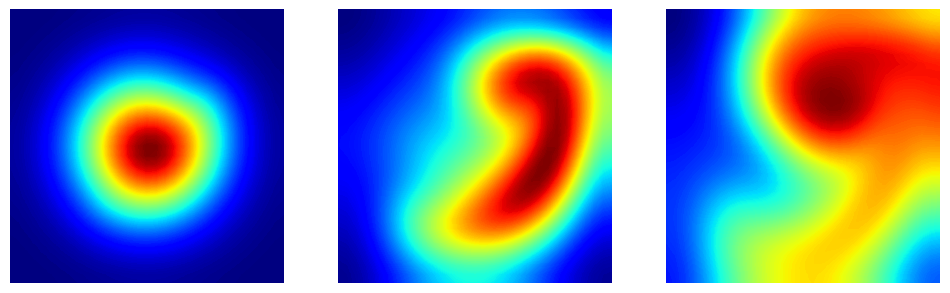

In [ ]:
#@title Plotting a trajectory at time 1, 25 and 50
fe.multiplot(u.T[[1, 25, 50]], (1, 3), Vh)


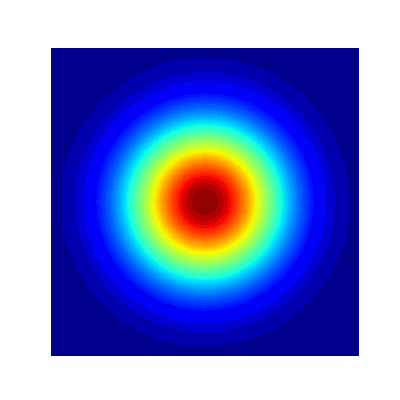

In [ ]:
#@title Plotting a trajectory evolving in time
fe.animate(u.T,Vh)


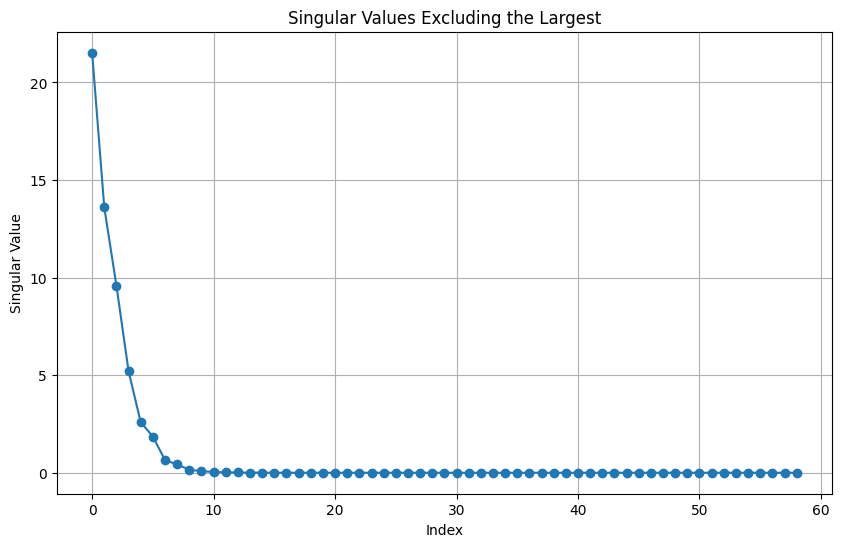

In [ ]:
#@title Singular Value Study and Reduced Matrix assmembly
from scipy.linalg import svd
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

snapshots = np.load('/content/snapshots.npy')

snapshots = np.array(snapshots)
U, s, Vt = svd(snapshots, full_matrices=False)


# Now you can apply SVD or any other analysis you wish to this giant matrix
from scipy.linalg import svd
U, s, Vt = svd(snapshots, full_matrices=False)

energy = np.cumsum(s**2) / np.sum(s**2)

# Determine number of modes to retain 99% of energy
n_modes = 20

V = U[:, :n_modes]

import matplotlib.pyplot as plt
import numpy as np

# Assuming 's' contains your singular values from the SVD
singular_values = s[1:60]  # Exclude the largest singular value

# Plotting the remaining singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o')
plt.title('Singular Values Excluding the Largest')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()




mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)

from scipy.sparse import csr_matrix

# Assuming we have a function to assemble FOM matrices
w1 = 5
w2 = 5
u, M_fom, S_fom, B_fom,B1_fom,B2_fom = Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)

M_rb = V.T @ M_fom @ V
S_rb = V.T @ S_fom @ V
B_rb = V.T @ B_fom @ V
B1_rb = V.T @ B1_fom @ V
B2_rb = V.T @ B2_fom @ V





In [ ]:
#@title Reconstruction Error on training set
import numpy as np
from fenics import *
from pyDOE import lhs
from scipy.sparse.linalg import spsolve
import dlroms.fespaces as fe
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

# Define the Convdiff_solver function as provided
# def Convdiff_solver(w1, w2, steps=50, dt=5e-4):
#     mesh = fe.unitsquaremesh(30, 30)
#     Vh = fe.space(mesh, 'CG', 1)  # FE space for u (chemical concentration)
#     bspace = fe.space(mesh, "CG", 1, scalar=False, bubble=True)  # FE space for b (transport field)

#     # Assembling relevant operators
#     v1, v2 = TrialFunction(Vh), TestFunction(Vh)
#     M = sp.csr_matrix(assemble(v1*v2*dx).array())  # mass matrix
#     S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2))*dx).array())  # stiffness (diffusion) matrix

#     b = Stokes_solver(w1, w2)
#     b1 = Stokes_solver(1, 0)
#     b2 = Stokes_solver(0, 1)
#     bf = fe.asvector(b, bspace)
#     bf1 = fe.asvector(b1, bspace)
#     bf2 = fe.asvector(b2, bspace)

#     B = sp.csr_matrix(assemble(inner(bf, grad(v1))*v2*dx).array())  # transport matrix
#     B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1))*v2*dx).array())
#     B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1))*v2*dx).array())

#     # Time-stepping scheme
#     def FOMstep(u0, dt, b):
#         A = M + dt*S + dt*B
#         F = M @ u0
#         return spsolve(A, F)

#     # Initial condition
#     x, y = fe.coordinates(Vh).T
#     u0 = np.exp(-16*(x-0.5)**2 - 16*(y-0.5)**2)

#     # Initialize storage for solution as a NumPy array
#     u = [u0]  # list of states in time

#     # Time loop
#     for n in range(steps):
#         uold = u[-1]
#         unew = FOMstep(uold, dt, b)
#         u.append(unew)

#     return np.stack(u).T, M, S, B, B1, B2

#from convdiff import Stokes_solver

mesh = fe.unitsquaremesh(30, 30)
Vh = fe.space(mesh, 'CG', 1) # FE space for u (chemical concentration)
bspace = fe.space(mesh, "CG", 1, scalar = False, bubble = True) # FE space for b (transport field)


# Load the original snapshots and perform SVD
U, s, Vt = svd(snapshots, full_matrices=False)
n_modes = 20
V = U[:, :n_modes]

# Define the parameter space for out-of-training data
n_samples_out_of_training = 2  # Number of out-of-training samples
parameter_ranges = [np.linspace(0, 1000, 1000), np.linspace(0, 1000, 1000)]  # Define parameter ranges

# Generate Latin Hypercube Samples for out-of-training data
lhs_samples_out = lhs(2, samples=n_samples_out_of_training, criterion='center')
params_out = np.array([parameter_ranges[0][((lhs_samples_out[:, i] * 999).astype(int))] for i in range(2)]).T

# Generate out-of-training snapshots
snapshots_out_of_training = []  # Initialize an empty list to store matrices
for w1, w2 in params_out:
    u, M, S, B, B1, B2 = Convdiff_solver(w1, w2)  # Get the time series data and matrices from the solver
    u = u.reshape(961, -1)  # Reshape u to have consistent dimensions
    if len(snapshots_out_of_training) == 0:
        snapshots_out_of_training = u  # If snapshots_out_of_training is empty, initialize it with the first u
    else:
        snapshots_out_of_training = np.hstack((snapshots_out_of_training, u))  # Stack u horizontally with the existing snapshots

# Project the out-of-training snapshots onto the reduced basis
reconstructed_snapshots = (V @ (V.T @ snapshots_out_of_training))

# Calculate the reconstruction error for each sample
reconstruction_errors = np.linalg.norm(snapshots_out_of_training - reconstructed_snapshots, axis=0)

# Calculate the average reconstruction error
average_reconstruction_error = np.mean(reconstruction_errors)

# Print the results
print(f"Average reconstruction error for {n_samples_out_of_training} out-of-training samples: {average_reconstruction_error}")


Average reconstruction error for 2 out-of-training samples: 0.3201039361783479


In [ ]:
#@title Time Stepping & One Shot Error Calculation
w1 = 900
w2 = 700
u, M_fom, S_fom, B_fom,B1_fom,B2_fom = Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)

def RBstep(u_rb, dt,w1,w2):
    # Assuming M_rb, S_rb, B1_rb, B2_rb, w1, w2 are defined elsewhere and are numpy arrays
    A_rb = M_rb + dt * S_rb + dt * (w1 * B1_rb + w2 * B2_rb)
    F_rb = M_rb @ u_rb
    return np.linalg.solve(A_rb, F_rb)

# Assuming 'V' is the matrix containing the left singular vectors (reduced basis vectors)
# and 'u' contains the simulation snapshots from the Full Order Model (FOM).

u0_rb = V.T @ u[:,0]  # Project the initial condition onto the reduced basis

# Number of time steps based on final time T and time step dt
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)

# Initialize storage for RB solution as a NumPy array
u_rb = np.zeros((V.shape[1], n_steps + 1))  # V.shape[1] is the number of reduced basis vectors
u_rb[:, 0] = u0_rb

# Time-stepping loop for the RB method
for n in range(n_steps):
    u_rb[:, n + 1] = RBstep(u_rb[:, n], dt,w1,w2)

# Optionally, convert back to full space for visualization or further analysis
u_rb_full = V @ u_rb  # This results in each column representing the solution at a time step

# If you need to transpose for further processing:

# Assuming 'u' is the original full matrix, and 'u_rb_full' is the reconstructed matrix after reduction and back-projection

error_vector = u - u_rb_full

# Calculate the norm of the difference (numerator of the relative error)
error_norm = np.linalg.norm(error_vector, axis=0)  # Since we transposed, use axis=0 to operate along columns

# Calculate the norm of the original vector (denominator of the relative error)
u_norm = np.linalg.norm(u, axis=0)  # Norm of each column in the original matrix

# Calculate the relative error for each column
relative_error = error_norm / u_norm

# Calculate the average of the relative errors
average_relative_error = np.mean(relative_error)

print("Average Relative Error:", average_relative_error)

Average Relative Error: 0.06347261675770101


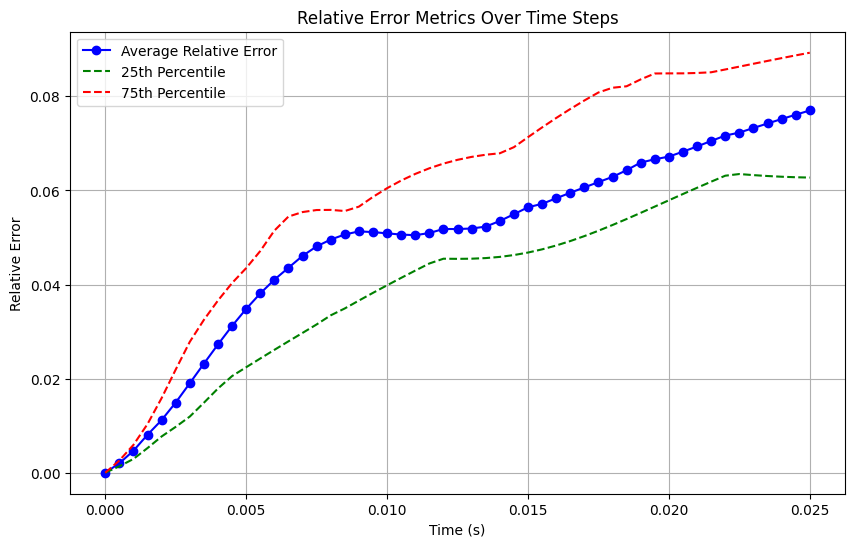

In [ ]:
#@title Average Error Calculation
import numpy as np
import matplotlib.pyplot as plt

def ROM_solver(u, V, dt, n_steps, w1, w2):
    # Initial condition projection
    u0_rb = V.T @ u[:, 0]
    u_rom = [u0_rb]

    # Time-stepping loop for the RB method
    for n in range(n_steps):
        u_rb_old = u_rom[-1]
        u_rb_new = RBstep(u_rb_old, dt, w1, w2)
        u_rom.append(u_rb_new)
    return np.stack(u_rom).T


# Define the problem dimensions and parameters
n_tests = 25
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)
weights_range = (0, 1000)

# Initialize the storage for errors
errors = np.zeros((n_tests, n_steps + 1))

# Loop over each test case
for test in range(n_tests):
    # Randomly sample weights w1 and w2
    w1 = np.random.uniform(*weights_range)
    w2 = np.random.uniform(*weights_range)

    # Generate the system matrices for RB using the Convdiff_solver (assuming it's implemented)
    u, a, b, c, d, e = Convdiff_solver(w1, w2, steps=50, dt=dt)

    # Call the ROM solver
    u_rb = ROM_solver(u, V, dt, n_steps, w1, w2)

    # Convert back to full space and compute error
    u_rb_full = V @ u_rb
    error_vector = u - u_rb_full
    error_norm = np.linalg.norm(error_vector, axis=0)
    u_norm = np.linalg.norm(u, axis=0)
    relative_error = error_norm / u_norm

    # Store the error for this test
    errors[test, :] = relative_error

# Calculate the average, 25th and 75th percentiles of the relative errors across all tests
average_relative_error = np.median(errors, axis=0)
percentile_25 = np.percentile(errors, 25, axis=0)
percentile_75 = np.percentile(errors, 75, axis=0)

# Plotting the average relative error and quantiles over time steps
plt.figure(figsize=(10, 6))
times = np.linspace(0, T_final, n_steps + 1)
plt.plot(times, average_relative_error, label='Average Relative Error', marker='o', color='blue')
plt.plot(times, percentile_25, label='25th Percentile', linestyle='--', color='green')
plt.plot(times, percentile_75, label='75th Percentile', linestyle='--', color='red')

plt.title('Relative Error Metrics Over Time Steps')
plt.xlabel('Time (s)')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#@title Time of FOM Solver
import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

def Convdiff_solver_time(w1, w2, steps=50, dt=5e-4):
    start_time = time.time()  # Start tracking time for Convdiff_solver

    # Assume 'assemble', 'TrialFunction', 'TestFunction', 'dx', 'inner', 'grad', 'Vh', 'fe.asvector', 'bspace' are defined elsewhere

    # Assembling relevant operators
    v1, v2 = TrialFunction(Vh), TestFunction(Vh)
    M = sp.csr_matrix(assemble(v1*v2*dx).array())  # mass matrix
    S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2))*dx).array())  # stiffness (diffusion) matrix

    stokes_time = 0  # To track time spent in Stokes_solver

    start_stokes = time.time()
    b = Stokes_solver(w1, w2)
    stokes_time += time.time() - start_stokes

    start_stokes = time.time()
    b1 = Stokes_solver(1, 0)
    stokes_time += time.time() - start_stokes

    start_stokes = time.time()
    b2 = Stokes_solver(0, 1)
    stokes_time += time.time() - start_stokes

    bf = fe.asvector(b, bspace)
    bf1 = fe.asvector(b1, bspace)
    bf2 = fe.asvector(b2, bspace)

    B = sp.csr_matrix(assemble(inner(bf, grad(v1))*v2*dx).array())  # transport matrix
    B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1))*v2*dx).array())
    B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1))*v2*dx).array())

    # Time-stepping scheme
    def FOMstep(u0, dt, b):
        A = M + dt*S + dt*B
        F = M @ u0
        return spsolve(A, F)

    # Initial condition
    x, y = fe.coordinates(Vh).T
    u0 = np.exp(-16*(x-0.5)**2 -16*(y-0.5)**2)

    # Initialize storage for solution as a NumPy array
    u = np.empty((len(u0), steps + 1))
    u[:, 0] = u0

    # Time loop
    for n in range(steps):
        u[:, n + 1] = FOMstep(u[:, n], dt, b)

    total_time = time.time() - start_time
    execution_time = total_time - stokes_time  # Subtracting the time spent in Stokes_solver

    return u, M, S, B, B1, B2, execution_time  # Adding execution_time to the returned values

# Usage
u, M, S, B, B1, B2, execution_time = Convdiff_solver_time(w1, w2)
print("Execution time excluding Stokes_solver:", execution_time)


Execution time excluding Stokes_solver: 0.23671936988830566


**Cost of FOM Model Escluding Stokes**

One Shot




In [ ]:
import time
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

def Convdiff_solver_time(w1, w2, steps=50, dt=5e-4):
    start_time = time.time()  # Start tracking time for Convdiff_solver


    # Assembling relevant operators
    v1, v2 = TrialFunction(Vh), TestFunction(Vh)
    M = sp.csr_matrix(assemble(v1*v2*dx).array())  # mass matrix
    S = sp.csr_matrix(assemble(inner(grad(v1), grad(v2))*dx).array())  # stiffness (diffusion) matrix

    stokes_time = 0  # To track time spent in Stokes_solver

    start_stokes = time.time()
    b = Stokes_solver(w1, w2)
    stokes_time += time.time() - start_stokes

    start_stokes = time.time()
    b1 = Stokes_solver(1, 0)
    stokes_time += time.time() - start_stokes

    start_stokes = time.time()
    b2 = Stokes_solver(0, 1)
    stokes_time += time.time() - start_stokes

    bf = fe.asvector(b, bspace)
    bf1 = fe.asvector(b1, bspace)
    bf2 = fe.asvector(b2, bspace)

    B = sp.csr_matrix(assemble(inner(bf, grad(v1))*v2*dx).array())  # transport matrix
    B1 = sp.csr_matrix(assemble(inner(bf1, grad(v1))*v2*dx).array())
    B2 = sp.csr_matrix(assemble(inner(bf2, grad(v1))*v2*dx).array())

    # Time-stepping scheme
    def FOMstep(u0, dt, b):
        A = M + dt*S + dt*B
        F = M @ u0
        return spsolve(A, F)

    # Initial condition
    x, y = fe.coordinates(Vh).T
    u0 = np.exp(-16*(x-0.5)**2 -16*(y-0.5)**2)

    # Initialize storage for solution as a NumPy array
    u = np.empty((len(u0), steps + 1))
    u[:, 0] = u0

    # Time loop
    for n in range(steps):
        u[:, n + 1] = FOMstep(u[:, n], dt, b)

    total_time = time.time() - start_time
    execution_time = total_time - stokes_time  # Subtracting the time spent in Stokes_solver

    return u, M, S, B, B1, B2, execution_time  # Adding execution_time to the returned values

# Usage
u, M, S, B, B1, B2, execution_time = Convdiff_solver_time(w1, w2)
print("Execution time excluding Stokes_solver:", execution_time)


Execution time excluding Stokes_solver: 0.2745950222015381


Average

In [ ]:
import random

def run_tests_and_calculate_average(number_of_tests=10):
    total_time = 0

    for _ in range(number_of_tests):
        # Generate random values for w1 and w2 between 0 and 100
        w1 = random.uniform(0, 100)
        w2 = random.uniform(0, 100)

        # Call Convdiff_solver and record the execution time
        _, _, _, _, _, _, execution_time = Convdiff_solver_time(w1, w2)
        total_time += execution_time

    # Calculate the average execution time
    average_time = total_time / number_of_tests
    return average_time

# Usage
average_execution_time = run_tests_and_calculate_average()
print("Average execution time excluding Stokes_solver over 20 tests:", average_execution_time)


Average execution time excluding Stokes_solver over 20 tests: 0.25618932247161863


**Cost of ROM Model**

In [ ]:
import numpy as np
import time  # Import the time module

def ROM_solver(u, V, dt, n_steps, w1, w2):
    # Initial condition projection
    u0_rb = V.T @ u[:, 0]
    u_rom = [u0_rb]

    # Time-stepping loop for the RB method
    for n in range(n_steps):
        u_rb_old = u_rom[-1]
        u_rb_new = RBstep(u_rb_old, dt, w1, w2)
        u_rom.append(u_rb_new)

    u_rb = np.stack(u_rom)
    return u_rb

# Define the problem dimensions and parameters
n_tests = 50
T_final = 0.025
dt = 5e-4
n_steps = int(T_final / dt)
weights_range = (0, 1000)

total_time_spent = 0  # Variable to store total time spent in the nested loop

# Loop over each test case
for test in range(n_tests):
    # Randomly sample weights w1 and w2
    w1 = np.random.uniform(*weights_range)
    w2 = np.random.uniform(*weights_range)

    # Start timing the ROM solver
    start_time = time.time()

    # Call the ROM solver
    u_rb = ROM_solver(u, V, dt, n_steps, w1, w2)

    # Stop timing after the ROM solver
    end_time = time.time()
    time_spent = end_time - start_time
    total_time_spent += time_spent  # Accumulate the time spent in this test's loop

# Output the average time spent in the ROM solver
print(f"Average Time: {total_time_spent / n_tests} seconds")



Average Time: 0.0032094001770019533 seconds


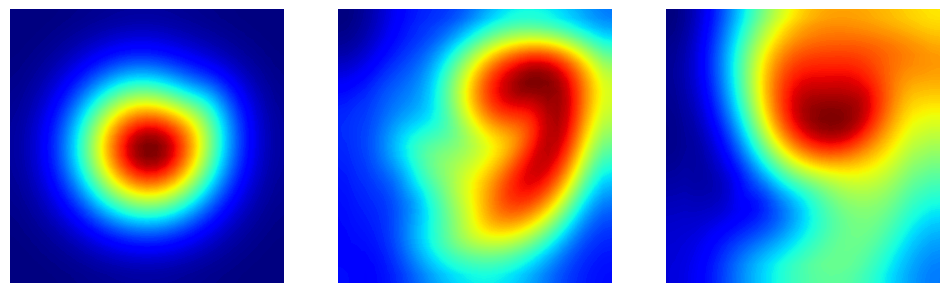

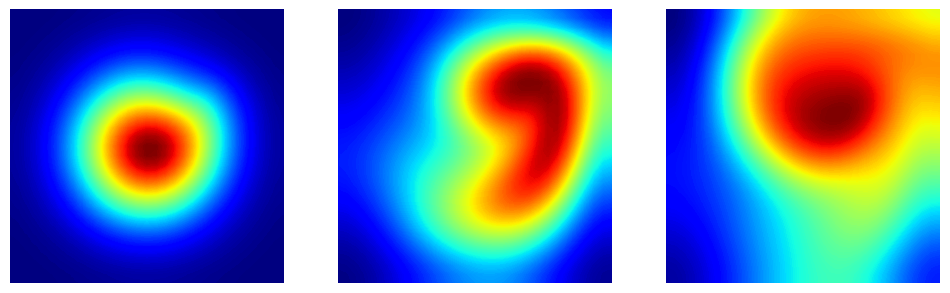

In [ ]:
u, M, S, B, B1, B2= Convdiff_solver(w1, w2, steps = 50, dt = 5e-4)
test = ROM_solver(u, V, dt, n_steps, w1, w2)
test.shape
test = test @ V.T
fe.multiplot(test[[1, 25, 50]], (1, 3), Vh)
fe.multiplot(u.T[[1, 25, 50]], (1, 3), Vh)

**NN Network**

In [2]:
#@title Fourier Modes Embedding Utilities
from dlroms.dnns import Weightless
import torch

class Fourier(Weightless):
    def __init__(self, k):
        super(Fourier, self).__init__()
        self.k = k

    def forward(self, x):
        z = [x[:,0], x[:,1], x[:,2]]
        for k in range(self.k):
            z.append((k*x[:,2]).cos())
            z.append((k*x[:,2]).sin())
        return torch.stack(z, axis = 1)


In [28]:
#@title Download the dataset
import gdown
gdown.download(id="1CctZk9gUIUyBVeXjsWE6K7nDBGdm2s7a", output="params.npy", quiet=False)
gdown.download(id="189KMTR6LbsCBpjz8KaRD12JoxqZsaipM", output="snapshots.npy", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1CctZk9gUIUyBVeXjsWE6K7nDBGdm2s7a
To: /content/params.npy
100%|██████████| 8.13k/8.13k [00:00<00:00, 7.08MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=189KMTR6LbsCBpjz8KaRD12JoxqZsaipM
From (redirected): https://drive.google.com/uc?id=189KMTR6LbsCBpjz8KaRD12JoxqZsaipM&confirm=t&uuid=4888b6c5-cee7-4a90-a5cd-f7df6b6144fa
To: /content/snapshots.npy
100%|██████████| 196M/196M [00:01<00:00, 178MB/s]


'snapshots.npy'

In [29]:
from dlroms import*
import numpy as np

mu = np.load("params.npy")
u = np.load("snapshots.npy")
mu, u = dv.tensor(mu), dv.tensor(u)
nh = 961
ntimes = 51
ndata = mu.shape[0]
ntrain = ndata*ntimes //2
p = mu.shape[-1]
print("Trajectories:\t%d." % ndata)
print("Timesteps:\t%d." % ntimes)
print("FOM dimension:\t%d." % nh)
print("Parameters:\t%d." % p)


mut = dv.zeros(ndata, ntimes, p+1)
times = dv.tensor(np.linspace(0, 3.5, ntimes))
for i in range(ndata):
    mut[i,:,:2] = mu[i]
    mut[i,:, 2] = times

Trajectories:	500.
Timesteps:	51.
FOM dimension:	961.
Parameters:	2.


In [30]:
u = u.reshape(-1, nh)
mut = mut.reshape(-1, p+1)

In [31]:
u.shape,mut.shape


(torch.Size([25500, 961]), torch.Size([25500, 3]))

In [32]:
import torch
import numpy as np
import random
import os

def set_seed(seed: int = 42):
    """
    Set seed for reproducibility.

    Args:
        seed (int): Seed to use for random number generators. Default is 42.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from torch.nn import Dropout as dropout
from dlroms.dnns import Weightless

class Dropout(Weightless):
    def __init__(self, p):
        super(Dropout, self).__init__()
        self.dp = dropout(p)
    def forward(self, x):
        return self.dp(x)
    def eval(self):
        self.dp.eval()


In [33]:
l2 = L2(Vh)
l2.cuda()
def error(utrue, upred):
    return (l2(utrue-upred).reshape(-1, ntimes).sum(axis = -1)/l2(utrue).reshape(-1, ntimes).sum(axis = -1)).mean()

In [34]:
ntrain
u.shape

torch.Size([25500, 961])

In [47]:
latent = 7
encoder = Dense(nh, 50) + Dense(50, latent)
decoder = Dense(latent, 50) + Dense(50, 100) + Dense(100, nh, activation=None)
autoencoder = DFNN(encoder + decoder)
autoencoder.He()



autoencoder.moveOn(dv)
set_seed(13) #So we can enjoy an unlucky training run ;)
autoencoder.train(u, u, ntrain = 400*51, epochs = 1250, loss = mse(l2))
autoencoder.eval()  # Set the model to evaluation mode
autoencoder.freeze()


		Train		Test
Epoch 3:	5.75e-03	2.13e-03.

>> ETA: 21m 17.81s.


KeyboardInterrupt: 

In [46]:
num2p(error(u[ntrain:], autoencoder(u[ntrain:])))

'21.68%'

In [ ]:
from dlroms import*

nu = encoder(u)
nu_mean, nu_std = nu[:ntrain].mean(axis = 0), nu[:ntrain].var(axis = 0).sqrt()
nu = (nu - nu_mean)/nu_std
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nu = nu.to(device)


fmodes = 10
phi = DFNN(Fourier(fmodes) + Dense(p+1+2*fmodes, 500) + Dense(500, latent, activation = None))

phi.He()
phi.moveOn(dv)
set_seed(17) #Here we go again, another unlucky run
phi.train(mut, nu, ntrain = ntrain, epochs = 2000, loss = mse(euclidean))
phi.freeze()

In [ ]:
dlrom = lambda mt: decoder(phi(mt)*nu_std + nu_mean)
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

**Visualization**

In [ ]:
from time import perf_counter
mu0 = np.array([50, 100])

mu0t = np.zeros((ntimes, p+1))
mu0t[:, 2] = times.cpu()
mu0t[:, :2] = mu0
mu0t = dv.tensor(mu0t)

t0 = perf_counter()
uROM = dlrom(mu0t)
t1 = perf_counter()
fe.multiplot(uROM[[1, 25, 50]], (1, 3), Vh)